In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd

import librosa
import IPython.display as ipd

from afritts_text_normalizer import tts_cleaner

[NeMo W 2024-03-02 06:31:57 optimizers:56] Apex was not found. Using the lamb or fused_adam optimizer will error out.


[NeMo I 2024-03-02 06:31:59 tokenize_and_classify:87] Creating ClassifyFst grammars.


In [3]:
dir_path = os.getcwd()

In [4]:
train = pd.read_csv(os.path.join(dir_path, "..", "data/intron-tts-train-public-28565.csv"))
dev = pd.read_csv(os.path.join(dir_path, "..", "data/intron-tts-dev-public-3330.csv"))
test = pd.read_csv(os.path.join(dir_path, "..", "data/intron-tts-test-public-4161.csv"))

data = pd.concat([train, dev, test])
len(data)

36056

In [5]:
not_exist = []
for i, item in data.iterrows():
    src = os.path.join(dir_path, "..", "afrispeech_16k_trimmed",
                       item.audio_paths[1:])
    if not os.path.exists(src):
        not_exist.append(item.audio_paths)

In [6]:
data = data[~data.audio_paths.isin(not_exist)]

In [7]:
len(not_exist), len(data)

(80, 35976)

In [8]:
# mos_data = pd.read_csv(os.path.join(dir_path, "..", "src/utils/mos_files_all.txt"),
#                       )
# data = pd.merge(data, mos_data, how="left", left_on="audio_ids", right_on="audio_ids")
# data = data[data.mos_score >= 2.5]

In [9]:
# remove 3 missing files
data = data[data.audio_ids != "24bfceabfa102cc1c1926d2049f56bbf"]
data = data[data.audio_ids != "790cdbb7907d0112bc737f0b06282dde"]
data = data[data.audio_ids != "4bffcdb03a445616d70eb1a859ac52a5"]

# Remove utterances with long duration, mostly noisy
data = data[data.duration <= 50.0].copy()

In [10]:
len(data)

35976

In [11]:
train.user_ids.nunique(), dev.user_ids.nunique(), test.user_ids.nunique()

(600, 76, 75)

In [12]:
data.user_ids.nunique(), data.duration.sum()/3600  # 751 speaker, 135 hours

(751, 133.52832222222222)

In [13]:
data.duration.sum() / 3600

133.52832222222222

In [14]:
len(data), data.audio_ids.nunique()

(35976, 35976)

In [15]:
# percentage of utterances with numbers

import re
def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

data["is_alnum"] = data.transcript.apply(lambda x: has_numbers(x))

In [16]:
data[data.is_alnum == True].duration.sum() / 3600 # 42 hours contain numbers, ~ 40%

41.3297775

In [17]:
split = data # train, dev, test
speakers = pd.pivot_table(data, values="duration",
              columns=["user_ids"], aggfunc="sum").T.reset_index()

speakers["duration"] = speakers["duration"]# /3600

speakers = speakers.sort_values("duration", ascending=False).reset_index(drop=True)
speakers.head(20)

,user_ids,duration
0,2db35217e91d8889c6f6f4bdee66a52f,4957.721
1,73f971bbef38880a86ac97680ab5a7f8,4929.179
2,6b5cd67595796bf5489893b69755f43f,4834.860
3,1269ac57cb62784a2abeec0b904ed615,4796.768
4,b883f5d99b7dfc05fc7bbeca0f926e9f,4675.044
5,f5a8238265acd295b474e3b67cde1dd5,4665.078
6,96ca0f339408b47bbed4b4ed6fdc4460,4570.077
7,a35a75f5541bce9a15063660e1028215,4506.899
8,2a477d9f7d285736be740fe77180b9c0,4197.769
9,bef1fe43fb65dfc614c001baeef2a381,4123.003


In [18]:
speakers.tail(10)

,user_ids,duration
741,b545a4ca235a7b72688a1c0b3eb6bde6,8.181
742,2493cba45cdf00e461b67e78d518a910,7.706
743,633ea93e9a3eb22f92e6c522c11f1f52,7.559
744,df4a2d9487db6e98bf0d8825220f9bf4,7.391
745,ce339a60ecffc5a72db4bd2489d206cc,7.379
746,1a1b8d8aace7c96a29d6b32d74ed90fd,7.311
747,2bb382f192f6a57300bdb0ef6fbd8ad3,7.077
748,eb5df6c57ad707440696d8478e655d78,6.603
749,c73de2fe9d445a8d192c5aac49a0e0bb,5.773
750,6b76a3d99dd1fe093782ef197cb92816,5.035


In [19]:
speakers_dict = {}
for i, item in speakers.iterrows():
    speakers_dict[item.user_ids] = item.duration

In [20]:
accents = pd.pivot_table(data, values="duration",
              columns=["accent"], aggfunc="sum").T.reset_index()
accents["duration"] = accents["duration"]

accents = accents.sort_values("duration", ascending=False).reset_index(drop=True)

In [21]:
accents.head(10) # don't forget to drop unknown accent

,accent,duration
0,Yoruba,113126.218
1,Hausa,110522.856
2,Unknown,36881.702
3,Swahili,36736.392
4,Igbo,28346.034
5,Zulu,23144.398
6,Ijaw,17126.945
7,Idoma,10673.228
8,Igala,9229.985
9,Afrikaans,7445.658


In [22]:
accents.tail(20)

,accent,duration
60,Bajju,182.389
61,Tula,167.667
62,Dera,166.638
63,Chichewa,149.858
64,Tsonga,124.148
65,Ogbia,78.476
66,Swati,77.642
67,Otjiherero,61.700
68,Ikulu,54.912
69,Lunguda,42.362


In [23]:
split = data # train, dev, test
speakers2 = pd.pivot_table(data, values="duration",
              columns=["country", "accent", "gender"], aggfunc="sum").T.reset_index()

speakers2["duration"] = speakers2["duration"]# /3600

speakers2 = speakers2.sort_values("duration", ascending=False).reset_index(drop=True)
speakers2.head(20)

,country,accent,gender,duration
0,NG,Yoruba,Male,63328.080
1,NG,Hausa,Male,57062.527
2,NG,Hausa,Female,53003.214
3,NG,Yoruba,Female,49789.957
4,KE,Swahili,Female,23695.523
5,ZA,Zulu,Female,22753.916
6,NG,Igbo,Female,17780.291
7,NG,Ijaw,Male,11829.030
8,KE,Unknown,Female,10855.926
9,NG,Igbo,Male,10565.743


In [24]:
speakers2.tail(20)

,country,accent,gender,duration
101,NG,Ikulu,Female,54.912
102,NG,Pidgin,Female,53.226
103,KE,Kikuyu,Female,51.627
104,UG,Luganda,Female,42.840
105,NG,Lunguda,Male,42.362
106,NG,Etsako,Female,34.521
107,NG,Ogba,Female,34.218
108,NG,"Hausa, Fulani",Male,33.247
109,NG,Anaang,Male,31.140
110,ZA,Portuguese,Male,30.236


In [25]:
# Test set: 4 speakers with 4 different accents
# test_data_unseen = data[data.accent.isin(["Swati", "Portuguese", "Ogbia", "Lunguda"])]

In [26]:
# len(test_data_unseen)

In [27]:
# data = data[~data.accent.isin(["Swati", "Portuguese", "Ogbia", "Lunguda"])]

data["user_ids_num"] = pd.factorize(data["user_ids"])[0]

In [28]:
# select 2 utterances per user_id as test set
from collections import defaultdict

# shuffle
data_sh = data.sample(frac=1, random_state=0).reset_index(drop=True)

user_id_map = defaultdict(int)
test_data_seen = []
train_val_data_seen = []

for i, item in data_sh.iterrows():
    
    # Only test on speaker with at least 5 mins data
    if speakers_dict[item.user_ids] <= 1200 or user_id_map[item.user_ids] == 5:
        train_val_data_seen.append(item)
        continue
    
    # if item.duration >= 1.0: # speaker embedding need 1 sec for extraction.
    test_data_seen.append(item)
    user_id_map[item.user_ids]+=1
    
test_data_seen = pd.DataFrame(test_data_seen)
train_val_data_seen = pd.DataFrame(train_val_data_seen)

In [29]:
len(test_data_seen), len(train_val_data_seen), len(test_data_seen)+len(train_val_data_seen), len(data_sh)


(735, 35241, 35976, 35976)

In [30]:
train_val_data_seen = train_val_data_seen.sample(frac=1, random_state=0).reset_index(drop=True)
val = train_val_data_seen[0: 200]
train = train_val_data_seen[200: ]

In [31]:
# test_data_unseen.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-test-unseen.csv", index=False)

train.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-train.csv", index=False)
val.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-dev.csv", index=False)

test_data_seen.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-test-seen.csv", index=False)

Normalize sentences


In [32]:
# test_data_unseen["transcript"] = test_data_unseen["transcript"].apply(tts_cleaner)

train["transcript"] = train["transcript"].apply(tts_cleaner)
val["transcript"] = val["transcript"].apply(tts_cleaner)
test_data_seen["transcript"] = test_data_seen["transcript"].apply(tts_cleaner)

[NeMo W 2024-03-02 06:52:46 nemo_logging:349] /tmp/ipykernel_42563/649144921.py:3: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead
    
    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      train["transcript"] = train["transcript"].apply(tts_cleaner)
    
[NeMo W 2024-03-02 06:52:52 nemo_logging:349] /tmp/ipykernel_42563/649144921.py:4: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead
    
    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      val["transcript"] = val["transcript"].apply(tts_cleaner)
    


In [33]:
# test_data_unseen.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-test-unseen-clean.csv", index=False)

train.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-train-clean.csv", index=False)
val.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-dev-clean.csv", index=False)

test_data_seen.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-test-seen-clean.csv", index=False)

In [35]:
speakers3 = pd.pivot_table(train, values="duration",
              columns=["country"], aggfunc="sum").T.reset_index()

speakers3["duration"] = speakers3["duration"]# /3600

speakers3 = speakers3.sort_values("duration", ascending=False).reset_index(drop=True)
speakers3.head(20)

,country,duration
0,NG,341118.626
1,ZA,57951.213
2,KE,57894.842
3,GH,8077.338
4,ZW,718.895
5,RW,511.729
6,SL,504.214
7,UG,302.586
8,ZM,149.858
9,US,8.181


In [39]:
train_upsampled = train.copy()
change = True

for country in speakers3["country"]:
    if country == "US": continue # that's yoruba in nigeria
    country_dur = train_upsampled[train_upsampled.country == country].duration.sum()
    if country_dur < 57894.842:
        total = int(57894.842 / country_dur)
        # oversample
        a = train_upsampled[train_upsampled.country == country].copy()
        train_a = pd.concat([a for _ in range(total)], ignore_index=True).reset_index(drop=True)
        train_upsampled = pd.concat([train_upsampled, train_a], ignore_index=True).reset_index(drop=True)

In [40]:
train_upsampled.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-train-ups-clean.csv", index=False)

In [41]:
speakers4 = pd.pivot_table(train_upsampled, values="duration",
              columns=["country"], aggfunc="sum").T.reset_index()

speakers4["duration"] = speakers4["duration"]# /3600

speakers4 = speakers4.sort_values("duration", ascending=False).reset_index(drop=True)
speakers4.head(20)

,country,duration
0,NG,341118.626
1,GH,64618.704
2,RW,58337.106
3,ZW,58230.495
4,UG,58096.512
5,ZM,57995.046
6,SL,57984.610
7,ZA,57951.213
8,KE,57894.842
9,US,8.181


In [26]:
import pandas as pd

In [5]:
test_data_unseen = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-test-unseen-clean.csv",)

train = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-train-clean.csv",)
val = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-dev-clean.csv",)

test_data_seen = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-test-seen-clean.csv",)


In [43]:
train_upsampled["count_t"] = train_upsampled.transcript.apply(lambda x: len(x))

In [44]:
train_upsampled.duration.sum()/3600

225.68572333333333

In [45]:
train_upsampled[train_upsampled.count_t < 400].duration.sum() / 3600

225.67786055555558

In [ ]:
# data.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/temp/intron-tts-all-public-0000", index=False)


In [47]:
with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/vits/filelists/afritts_train.txt", "w+") as f4:
    for i, item in train.iterrows():
        print(f"DUMMY4/{item.audio_paths[1:]}|{item.user_ids_num}|{item.transcript}", file=f4)

In [46]:
with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/vits/filelists/afritts_train_ups.txt", "w+") as f4:
    for i, item in train_upsampled.iterrows():
        print(f"DUMMY4/{item.audio_paths[1:]}|{item.user_ids_num}|{item.transcript}", file=f4)
        

In [48]:
with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/vits/filelists/afritts_dev.txt", "w+") as f4:
    for i, item in val.iterrows():
        print(f"DUMMY4/{item.audio_paths[1:]}|{item.user_ids_num}|{item.transcript}", file=f4)

In [49]:
with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/vits/filelists/afritts_test_seen.txt", "w+") as f4:
    for i, item in test_data_seen.iterrows():
        print(f"DUMMY4/{item.audio_paths[1:]}|{item.user_ids_num}|{item.transcript}", file=f4)

In [50]:
train.user_ids_num.values.max()

750

In [51]:
# combining with VCTK

In [48]:
train["user_ids_num"] = train["user_ids_num"].apply(lambda x: x+109)

with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/vits/filelists/afritts_vctk_train.txt", "w+") as f4:
    for i, item in train.iterrows():
        print(f"DUMMY4/{item.audio_paths[1:]}|{item.user_ids_num}|{item.transcript}", file=f4)

[NeMo W 2024-02-21 01:46:29 nemo_logging:349] /tmp/ipykernel_22456/3833906502.py:1: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead
    
    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      train["user_ids_num"] = train["user_ids_num"].apply(lambda x: x+109)
    


In [49]:
val["user_ids_num"] = val["user_ids_num"].apply(lambda x: x+109)

with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/vits/filelists/afritts_vctk_dev.txt", "w+") as f4:
    for i, item in val.iterrows():
        print(f"DUMMY4/{item.audio_paths[1:]}|{item.user_ids_num}|{item.transcript}", file=f4)

[NeMo W 2024-02-21 01:46:35 nemo_logging:349] /tmp/ipykernel_22456/2927864343.py:1: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead
    
    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      val["user_ids_num"] = val["user_ids_num"].apply(lambda x: x+109)
    


In [50]:
test_data_seen["user_ids_num"] = test_data_seen["user_ids_num"].apply(lambda x: x+109)

with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/vits/filelists/afritts_vctk_test_seen.txt", "w+") as f4:
    for i, item in test_data_seen.iterrows():
        print(f"DUMMY4/{item.audio_paths[1:]}|{item.user_ids_num}|{item.transcript}", file=f4)
        

In [51]:
train.user_ids_num.values.max()

855

In [9]:
# oversample train per accent

train = pd.read_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-train-clean.csv",)

split = train # train, dev, test
speakers2 = pd.pivot_table(train, values="duration",
              columns=["country"], aggfunc="sum").T.reset_index()

speakers2["duration"] = speakers2["duration"]# /3600

speakers2 = speakers2.sort_values("duration", ascending=False).reset_index(drop=True)
speakers2.head(20)

,country,duration
0,NG,342542.613
1,KE,58254.316
2,ZA,57758.806
3,GH,8062.113
4,ZW,687.744
5,RW,492.412
6,SL,481.285
7,UG,291.945
8,ZM,149.858
9,US,8.181


In [68]:
train.to_csv("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/data/afritts-train-clean-upsamp2.csv", index=False)



In [69]:
with open("/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/src/vits/filelists/temp/afritts_train_upsamp.txt", "w+") as f4:
    for i, item in train.iterrows():
        print(f"DUMMY4/{item.audio_paths[1:]}|{item.user_ids_num}|{item.transcript}", file=f4)

In [50]:
57758.806 / 149.858

385.4235743170201

In [66]:
change = True
# for i in range(386):
#     change = False
for country in speakers2["country"]:
    if country == "US": continue # that's yoruba in nigeria
    country_dur = train[train.country == country].duration.sum()
    if country_dur < 57758.806:
        total = int(57758.806 / country_dur)
        # oversample
        a = train[train.country == country].copy()
        train_a = pd.concat([a for _ in range(total)], ignore_index=True).reset_index(drop=True)
        train = pd.concat([train, train_a], ignore_index=True).reset_index(drop=True)
        #     change = True
        # else:
        #     change = False
        # print(country)

In [70]:
split = train # train, dev, test
speakers2 = pd.pivot_table(train, values="duration",
              columns=["country"], aggfunc="sum").T.reset_index()

speakers2["duration"] = speakers2["duration"]/3600

speakers2 = speakers2.sort_values("duration", ascending=False).reset_index(drop=True)
speakers2.tail(20)

,country,duration
0,NG,95.150726
1,GH,17.915807
2,KE,16.181754
3,SL,16.176524
4,RW,16.140171
5,ZM,16.068108
6,UG,16.056975
7,ZW,16.047360
8,ZA,16.044113
9,US,0.002272


In [10]:
# select 1 sentence per accent per region for objective evaluation

In [ ]:
# Test set: 10 speakers seen in training

In [ ]:
speakers.tail(20)

In [1]:
import librosa
import IPython.display as ipd

In [ ]:
data[0:1].audio_paths.values.item()

In [ ]:
data[data.audio_paths == '/AfriSpeech-TTS/train/9b1a7865-4b74-486e-8223-9117e2ea592a/9b1f7d24a96824967ed3a1ae5d3c44cd_OWVB6wln.wav']

In [ ]:
'/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/../AfriSpeech-TTS/train/9b1a7865-4b74-486e-8223-9117e2ea592a/9b1f7d24a96824967ed3a1ae5d3c44cd_OWVB6wln.wav'


In [ ]:
filepath = '/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/afrispeech_16k/1e759a52b9a7588771a8d281dd480fce.wav'

audio, sr = librosa.load(filepath, sr=16000)

ipd.Audio(audio, rate=sr)

In [4]:
filepath = '/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/train/3bac4989-69c5-4ffc-aad4-be9796fd80cd/eeaedf7e2d69ff886b61260639481b23_QJgkxpqZ.wav'

audio, sr = librosa.load(filepath, sr=16000)

ipd.Audio(audio, rate=sr)

In [ ]:
audio.shape

In [ ]:
sr

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import librosa.display

# parameters
n_fft=1024
hop_length=256
window="hann"
# sr=16000
n_mels=80
fmin=0
fmax=8000
win_length=n_fft
power=1.0
n_iter=64

def plot_spec(spec, aspect=2):
    if spec is not None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = plt.imshow(spec, origin="lower",)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("Colorbar")
        ax.set_aspect(aspect)
        plt.show()

In [5]:
audio.shape

(283312,)

In [9]:
filepath = '/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/test/1b12643a-d3d1-4759-bbd9-8de6acc3e943/5443a331e4bf5b8560a588705c837d98_DLPkk3uA.wav'

audio, sr = librosa.load(filepath, sr=16000)

ref_mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, S=None, n_fft=n_fft, 
                                          hop_length=hop_length, 
                                          win_length=win_length, 
                                          window=window, power=power,
                                          n_mels=n_mels, fmin=fmin, fmax=fmax,)
# vocoder expects a log mel-spectrogram
eps = 1e-9
ref_log_mel = np.log(ref_mel_spec + eps)

In [10]:
ipd.Audio(audio, rate=sr)

NameError: name 'ipd' is not defined

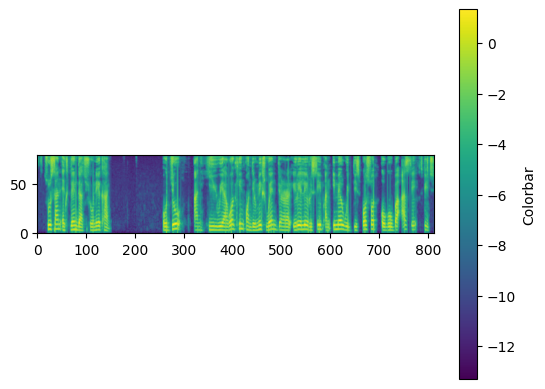

In [11]:
plot_spec(ref_log_mel,)

In [ ]:
# denoised
filepath = '/srv/storage/talc2@talc-data2.nancy/multispeech/calcul/users/sogun/AfriSpeech-TTS/b53792d173f1ac743819e81f240a3a07_ooKIycx6_dn.wav'

audio_dn, sr = librosa.load(filepath)

dn_mel_spec = librosa.feature.melspectrogram(y=audio_dn, sr=sr, S=None, n_fft=n_fft, 
                                          hop_length=hop_length, 
                                          win_length=win_length, 
                                          window=window, power=power,
                                          n_mels=n_mels, fmin=fmin, fmax=fmax,)
# vocoder expects a log mel-spectrogram
eps = 1e-9
dn_log_mel = np.log(dn_mel_spec + eps)

In [ ]:
ipd.Audio(audio, rate=sr)

In [ ]:
plot_spec(dn_log_mel,2.5)